In [1]:
# ============================================================
# 1. Install DeepXDE (run once in Colab)
# ============================================================
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.1 MB/s eta 0:00:00


In [2]:
# ============================================================
# 2. Imports & backend
# ============================================================
import deepxde as dde
import numpy as np
from deepxde.backend import tf

dde.backend.set_default_backend("tensorflow")

No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
# ============================================================
# 3. PDE: diffusion–reaction equation
# ============================================================
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1.0

    return (
        dy_t
        - d * dy_xx
        - tf.exp(-x[:, 1:])
        * (
            3 * tf.sin(2 * x[:, 0:1]) / 2
            + 8 * tf.sin(3 * x[:, 0:1]) / 3
            + 15 * tf.sin(4 * x[:, 0:1]) / 4
            + 63 * tf.sin(8 * x[:, 0:1]) / 8
        )
    )

In [4]:
# ============================================================
# 4. Exact solution (used for metrics & testing)
# ============================================================
def func(x):
    return np.exp(-x[:, 1:]) * (
        np.sin(x[:, 0:1])
        + np.sin(2 * x[:, 0:1]) / 2
        + np.sin(3 * x[:, 0:1]) / 3
        + np.sin(4 * x[:, 0:1]) / 4
        + np.sin(8 * x[:, 0:1]) / 8
    )

In [5]:
# ============================================================
# 5. Geometry & time domain
# ============================================================
geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0.0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# ============================================================
# 6. Data object
#    (Hard BCs & ICs via output transform → no BC list needed)
# ============================================================
data = dde.data.TimePDE(
    geomtime,
    pde,
    [],
    num_domain=320,
    solution=func,
    num_test=80000,
)

In [8]:
# ============================================================
# 7. Neural network
# ============================================================
layer_size = [2] + [30] * 6 + [1]
net = dde.nn.FNN(
    layer_size,
    activation="tanh",
    kernel_initializer="Glorot uniform",
)

In [9]:
# ============================================================
# 8. Output transform (hard IC + BC)
# ============================================================
def output_transform(x, y):
    return (
        x[:, 1:2] * (np.pi**2 - x[:, 0:1] ** 2) * y
        + tf.sin(x[:, 0:1])
        + tf.sin(2 * x[:, 0:1]) / 2
        + tf.sin(3 * x[:, 0:1]) / 3
        + tf.sin(4 * x[:, 0:1]) / 4
        + tf.sin(8 * x[:, 0:1]) / 8
    )

net.apply_output_transform(output_transform)


In [10]:
# ============================================================
# 9. Model compilation
# ============================================================
model = dde.Model(data, net)
model.compile(
    optimizer="adam",
    lr=1e-3,
    metrics=["l2 relative error"],  # SAFE because solution=func
)

Compiling model...
'compile' took 0.051309 s



In [11]:
# ============================================================
# 10. Training
# ============================================================
losshistory, train_state = model.train(iterations=20000)


Training model...

Step      Train loss    Test loss     Test metric   
0         [2.08e+01]    [2.13e+01]    [1.98e+00]    
1000      [2.02e+00]    [2.05e+00]    [5.61e-02]    
2000      [1.29e+00]    [1.29e+00]    [4.17e-02]    
3000      [8.52e-01]    [8.33e-01]    [3.03e-02]    
4000      [3.75e-01]    [3.69e-01]    [2.64e-02]    
5000      [2.04e-02]    [2.00e-02]    [8.14e-03]    
6000      [8.22e-03]    [8.53e-03]    [5.14e-03]    
7000      [4.19e-02]    [4.24e-02]    [1.15e-01]    
8000      [2.53e-03]    [2.83e-03]    [2.22e-03]    
9000      [1.89e-03]    [2.13e-03]    [1.91e-03]    
10000     [1.39e-02]    [1.42e-02]    [9.09e-02]    
11000     [1.43e-03]    [1.61e-03]    [1.03e-02]    
12000     [1.13e-02]    [1.15e-02]    [8.62e-02]    
13000     [7.78e-04]    [9.22e-04]    [1.76e-03]    
14000     [1.10e-02]    [1.12e-02]    [3.37e-02]    
15000     [1.36e-03]    [1.46e-03]    [2.14e-02]    
16000     [5.08e-03]    [5.20e-03]    [5.65e-02]    
17000     [8.67e-04]    [9.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


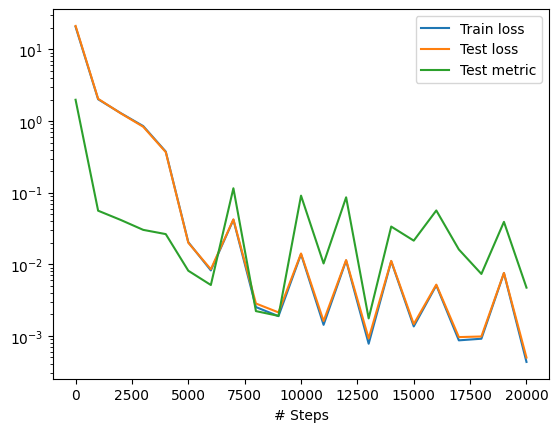

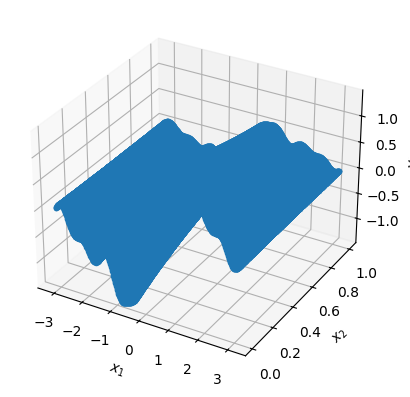

In [12]:
# ============================================================
# 11. Save & plot results
# ============================================================
dde.saveplot(losshistory, train_state, issave=True, isplot=True)